# VA Group 59
# Group Member - Ranjoy Sen

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tensorflow_hub import load
from transformers import pipeline
import random
import seaborn as sns
import mediapipe as mp

DEPENDENCIES = {
    "TensorFlow": tf.__version__,
    "Matplotlib": matplotlib.__version__,
    "numpy": np.__version__,
    "cv2": cv2.__version__,
    "sns": sns.__version__,
    "mp": mp.__version__,
}
print("Dependencies:", DEPENDENCIES)

Dependencies: {'TensorFlow': '2.16.2', 'Matplotlib': '3.9.4', 'numpy': '1.26.4', 'cv2': '4.11.0', 'sns': '0.13.2', 'mp': '0.10.21'}


# Video properties

In [3]:
# Load the video
video_path = "pedestrian_crossover.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Total Frames: {frame_count}, FPS: {fps}, Width: {width}, Height: {height}")



Total Frames: 913, FPS: 29.97002997002997, Width: 960, Height: 540


# Low-level features: color, shape, motion detection

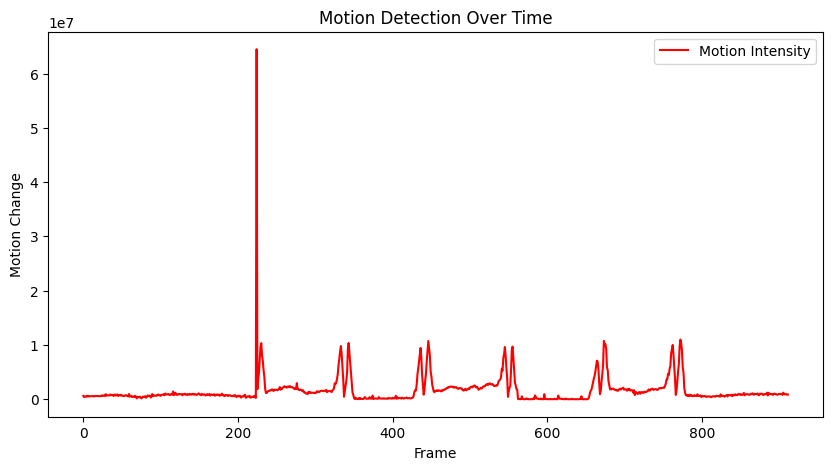

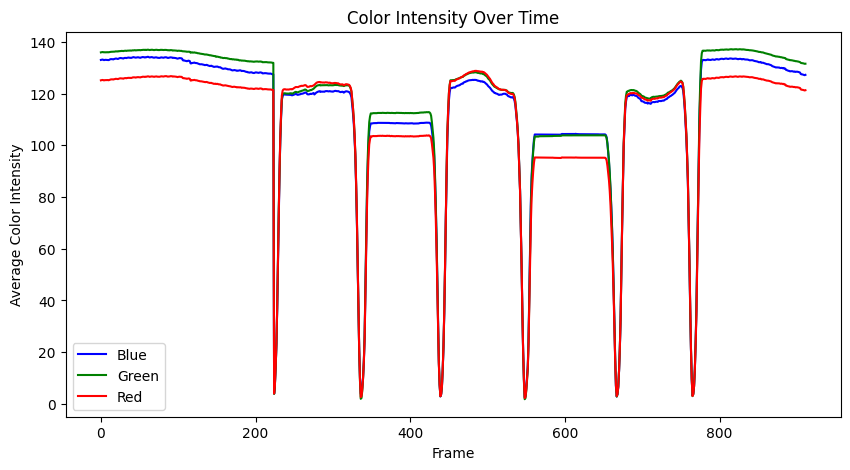

In [4]:
# Extract low-level features: color, shape, motion detection
def extract_low_level_features(video_path):
    """
    Extracts low-level features such as color changes, shape detection using edge detection,
    and motion detection using frame differences.
    """
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    motion_frames = []
    color_changes = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Extract color features by computing average RGB values
        avg_color = np.mean(frame, axis=(0, 1))
        color_changes.append(avg_color)
        
        # Shape detection using edge detection (Canny algorithm)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        
        # Motion detection using frame difference
        frame_diff = cv2.absdiff(prev_gray, gray)
        motion_frames.append(np.sum(frame_diff))
        prev_gray = gray
    
    cap.release()
    
    # Plot motion intensity over time
    plt.figure(figsize=(10, 5))
    plt.plot(motion_frames, label='Motion Intensity', color='r')
    plt.xlabel('Frame')
    plt.ylabel('Motion Change')
    plt.title('Motion Detection Over Time')
    plt.legend()
    plt.show()
    
    # Plot color changes over time
    color_changes = np.array(color_changes)
    plt.figure(figsize=(10, 5))
    plt.plot(color_changes[:, 0], label='Blue', color='b')
    plt.plot(color_changes[:, 1], label='Green', color='g')
    plt.plot(color_changes[:, 2], label='Red', color='r')
    plt.xlabel('Frame')
    plt.ylabel('Average Color Intensity')
    plt.title('Color Intensity Over Time')
    plt.legend()
    plt.show()

# Run low-level feature extraction
extract_low_level_features(video_path)

# Mid-level features: Shot boundary detection, key frame extraction, object detection

In [16]:
# Function to detect shot boundaries
def detect_shot_boundaries(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    shot_boundaries = []
    
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray)
        score = np.sum(diff)
        
        if score > 1e7:  # Threshold for shot boundary
            shot_boundaries.append(frame_index)
        
        prev_gray = gray
        frame_index += 1
    
    cap.release()
    print("Shot boundaries detected at frames:", shot_boundaries)
    return shot_boundaries

# Run Detect shot boundaries
shot_boundaries = detect_shot_boundaries(video_path)

Shot boundaries detected at frames: [224, 230, 343, 446, 673, 674, 675, 772, 773]


In [6]:
# Function to extract keyframes based on Structural Similarity Index (SSIM)
def extract_keyframes(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    success, prev_frame = cap.read()
    prev_frame = tf.image.convert_image_dtype(tf.image.rgb_to_grayscale(prev_frame), dtype=tf.float32)
    keyframes = [prev_frame.numpy()]
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames
    
    for i in range(1, num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        success, frame = cap.read()
        if success:
            gray_frame = tf.image.convert_image_dtype(tf.image.rgb_to_grayscale(frame), dtype=tf.float32)
            ssim_score = tf.image.ssim(prev_frame, gray_frame, max_val=1.0)
            if ssim_score < 0.75:  # Change threshold as needed
                keyframes.append(frame)
                prev_frame = gray_frame
    cap.release()
    return keyframes

# Extract and display keyframes
keyframes = extract_keyframes(video_path)
plt.figure(figsize=(15, 5))
for i, frame in enumerate(keyframes):
    plt.subplot(1, len(keyframes), i + 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

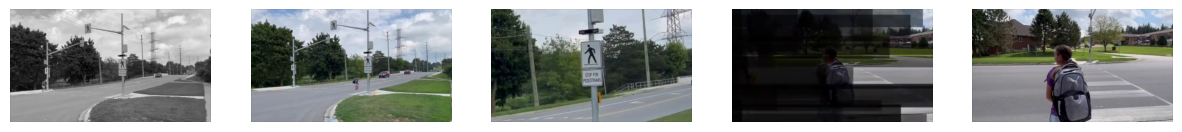

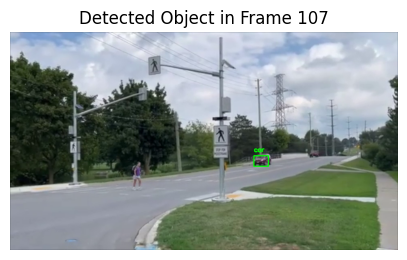

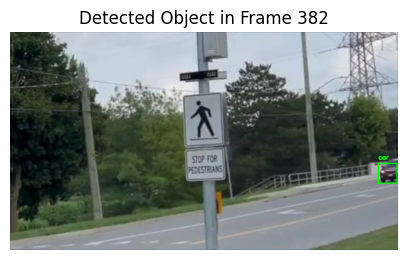

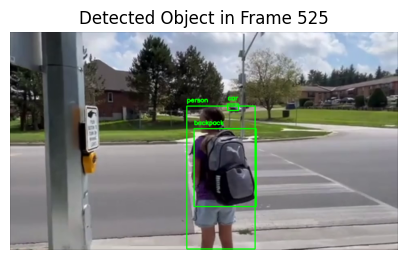

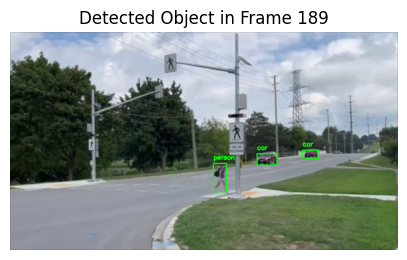

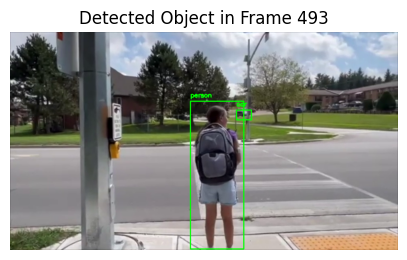

In [14]:
# Load TensorFlow Object Detection model
detector = load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

# COCO dataset labels
coco_labels = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane", 6: "bus", 7: "train", 8: "truck", 
    9: "boat", 10: "traffic light", 11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench", 
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep", 21: "cow", 22: "elephant", 23: "bear", 
    24: "zebra", 25: "giraffe", 27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase", 
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite", 39: "baseball bat", 40: "baseball glove", 
    41: "skateboard", 42: "surfboard", 43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork", 
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple", 54: "sandwich", 55: "orange", 56: "broccoli", 
    57: "carrot", 58: "hot dog", 59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch", 64: "potted plant", 
    65: "bed", 67: "dining table", 70: "toilet", 72: "TV", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard", 
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink", 82: "refrigerator", 84: "book", 
    85: "clock", 86: "vase", 87: "scissors", 88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# Object detection function with random frame display and object labels
def detect_objects(video_path):
    cap = cv2.VideoCapture(video_path)
    detected_frames = []
    frame_indices = []
    frame_index = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        input_tensor = tf.convert_to_tensor(frame, dtype=tf.uint8)[tf.newaxis, ...]
        detections = detector(input_tensor)
        
        for i in range(len(detections['detection_scores'][0])):
            if detections['detection_scores'][0][i] > 0.5:  # Confidence threshold
                y1, x1, y2, x2 = detections['detection_boxes'][0][i].numpy()
                h, w, _ = frame.shape
                x1, x2 = int(x1 * w), int(x2 * w)
                y1, y2 = int(y1 * h), int(y2 * h)
                label_index = int(detections['detection_classes'][0][i].numpy())
                label = coco_labels.get(label_index, "unknown")
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                # Save frames with detected objects
                detected_frames.append(frame.copy())
                frame_indices.append(frame_index)
                
        frame_index += 1
        cv2.imshow('Object Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Print a few random frames with detected objects
    if detected_frames:
        selected_indices = random.sample(range(len(detected_frames)), min(5, len(detected_frames)))
        for idx in selected_indices:
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(detected_frames[idx], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Detected Object in Frame {frame_indices[idx]}")
            plt.show()

# Run object detection
detect_objects(video_path)

# High-level features: Semantic Concepts, Emotional Features, Contextual Features

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


Frame 0 - Semantic: Scene at frame 0: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.6774299144744873}]
Frame 1 - Semantic: Scene at frame 1: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8330380320549011}]
Frame 2 - Semantic: Scene at frame 2: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8852750658988953}]
Frame 3 - Semantic: Scene at frame 3: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8616158366203308}]
Frame 4 - Semantic: Scene at frame 4: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8821444511413574}]
Frame 5 - Semantic: Scene at frame 5: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8808038830757141}]
Frame 6 - Semantic: Scene at frame 6: Pedestrian crossing scenario, Emotion: [{'label': 'POSITIVE', 'score': 0.8813413381576538}]
Frame 7 - Semantic: Scene at frame 7: Pedestrian crossing scenario, Emotion: [{'label': 'P

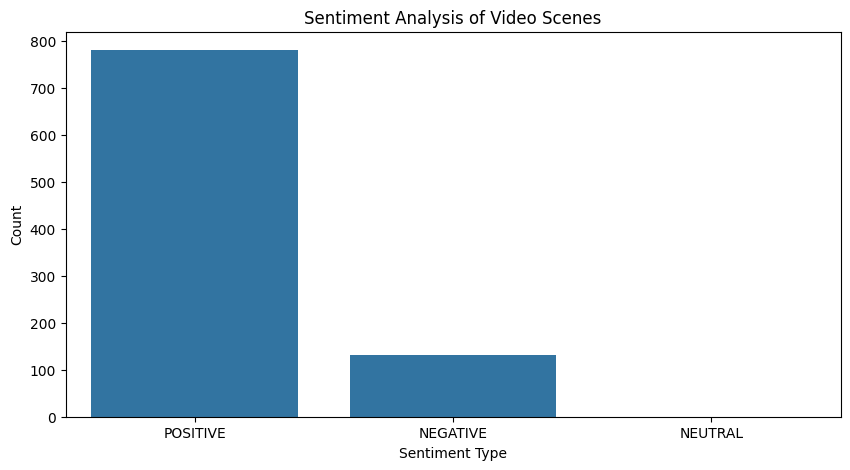

In [4]:
# High-level feature extraction

# Semantic, Emotional, and Contextual Feature Extraction
sentiment_analysis = pipeline("sentiment-analysis")

# Function to extract Semantic, Emotional, and Contextual Features
def extract_high_level_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_index = 0
    semantic_descriptions = []
    emotions = []
    frame_numbers = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Generate a textual description of the scene (Placeholder for AI-based captioning)
        scene_description = f"Scene at frame {frame_index}: Pedestrian crossing scenario"
        semantic_descriptions.append(scene_description)
        
        # Perform sentiment analysis
        emotion_result = sentiment_analysis(scene_description)
        emotions.append(emotion_result[0]['label'])
        frame_numbers.append(frame_index)
        
        print(f"Frame {frame_index} - Semantic: {scene_description}, Emotion: {emotion_result}")
        
        frame_index += 1
    
    cap.release()
    print("High-Level Feature Extraction Completed!")
    
    # Visualizing sentiment analysis results
    plt.figure(figsize=(10, 5))
    sns.countplot(x=emotions, order=['POSITIVE', 'NEGATIVE', 'NEUTRAL'])
    plt.title("Sentiment Analysis of Video Scenes")
    plt.xlabel("Sentiment Type")
    plt.ylabel("Count")
    plt.show()

# Run high-level feature extraction
extract_high_level_features(video_path)


# Motion Tracking in Video

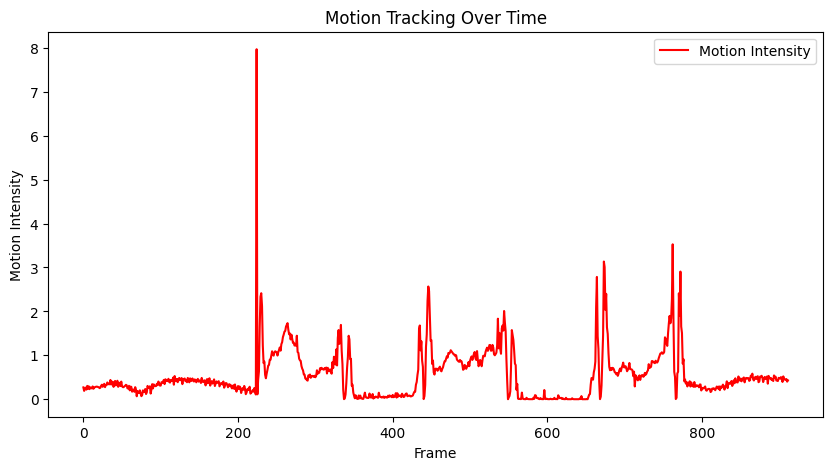

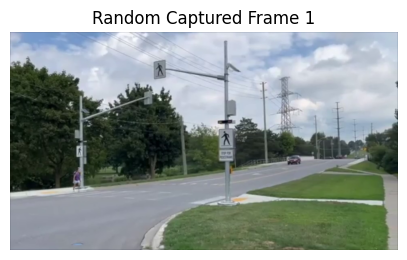

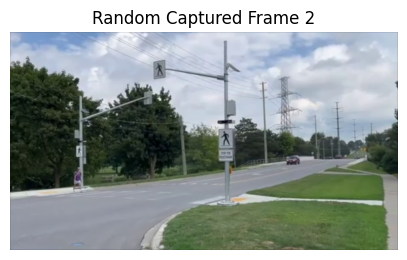

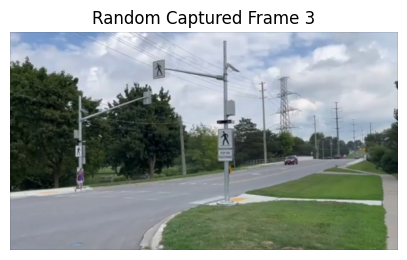

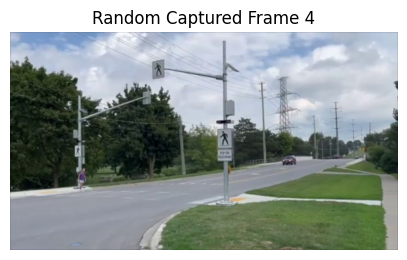

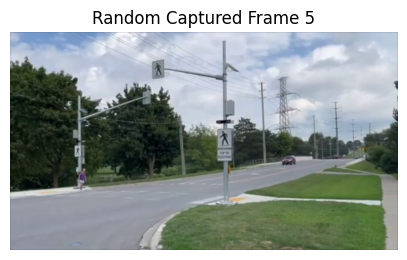

In [5]:
# Motion Tracking in Video
# Motion Tracking in Video
def motion_tracking(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(prev_frame)
    mask[..., 1] = 255  # Set mask to green for visualization
    motion_intensity = []
    captured_frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        
        # Compute motion vectors
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mask[..., 0] = ang * 180 / np.pi / 2
        mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        motion_intensity.append(np.mean(mag))
        
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        cv2.imshow('Motion Tracking', rgb)
        
        if len(captured_frames) < 5 and np.mean(mag) > np.percentile(motion_intensity, 80):
            captured_frames.append(frame)
        
        if cv2.waitKey(30) & 0xFF == 27:
            break
        
        prev_gray = gray
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Plot motion intensity over time
    plt.figure(figsize=(10, 5))
    plt.plot(motion_intensity, label='Motion Intensity', color='r')
    plt.xlabel('Frame')
    plt.ylabel('Motion Intensity')
    plt.title('Motion Tracking Over Time')
    plt.legend()
    plt.show()
    
    # Display captured frames with high motion
    for i, frame in enumerate(captured_frames[:5]):  # Show up to 5 captured frames
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Random Captured Frame {i+1}')
        plt.axis('off')
        plt.show()

# Run motion tracking
motion_tracking(video_path)